In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from PIL import Image
import os
import torchvision.transforms as transforms
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

folder_path = "20230530_segm_black_mouse_mnSLA_red_and_black_back"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

train_df = pd.read_csv("train_data.csv")
test = pd.read_csv("test_data.csv")

cuda:0


In [2]:
def make_csv_files(folder_path, folder):
    images_folder = folder_path + "/" + folder + "images"
    masks_folder = folder_path + "/" + folder + "masks"

    images_files = os.listdir(images_folder)
    masks_files = os.listdir(masks_folder)

    image_paths = [os.path.join(folder + "images", file) for file in images_files]
    mask_paths = [os.path.join(folder + "masks", file) for file in masks_files]

    data = {'orig_image': image_paths, 'mask_image': mask_paths}
    df = pd.DataFrame(data)

    csv_file_path = "train_data.csv" if folder == "" else "test_data.csv"

    df.to_csv(csv_file_path, index=False)

In [3]:
# make_csv_files(folder_path, "")
# make_csv_files(folder_path, "test_")

In [4]:
def draw(orig_image, mask_image):
    fig, axes = plt.subplots(1, 2)

    axes[0].imshow(orig_image)
    axes[0].set_title('Original Image')
    
    axes[1].imshow(mask_image)
    axes[1].set_title('Mask Image')

    plt.tight_layout()
    plt.show()

In [5]:
def calculate_iou(pred, target):
    intersection = np.logical_and(pred, target).sum().item()
    union = np.logical_or(pred, target).sum().item()
    
    iou = intersection / union if union > 0 else 0.0
    return iou

### Preprocessing (подготовка данных)

In [6]:
class ImagesDataset(Dataset):
    def __init__(self, folder, data, transform_image, transform_mask):
      self.folder = folder
      self.data = data.copy()
      self.orig_image_paths = [os.path.join(folder, filename) for filename in data['orig_image'].copy()]
      self.mask_image_paths = [os.path.join(folder, filename) for filename in data['mask_image'].copy()]
      self.transform_image = transform_image
      self.transform_mask = transform_mask

    def __len__(self):
        return len(self.orig_image_paths)

    def __getitem__(self, idx):
        orig_image_path = self.orig_image_paths[idx]
        mask_image_path = self.mask_image_paths[idx]
        orig_image = Image.open(orig_image_path).convert('RGB')
        mask_image = Image.open(mask_image_path).convert('L')

        orig_image = self.transform_image(orig_image)
        orig_image = orig_image.to(orig_image)
        
        mask_image = self.transform_mask(mask_image)
        mask_image = mask_image.to(mask_image)

        return orig_image.float(), mask_image.float()

In [7]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(train_df, test_size=0.1 , random_state=42)

size = (256, 256)
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
batch_size = 16

transform_image = transforms.Compose([transforms.Resize(size), transforms.ToTensor(), transforms.Normalize(mean=mean, std=std)])

transform_mask = transforms.Compose([transforms.Resize(size), transforms.ToTensor()])

train_dataset = ImagesDataset(folder_path, train, transform_image, transform_mask)
val_dataset = ImagesDataset(folder_path, val, transform_image, transform_mask)
test_dataset = ImagesDataset(folder_path, test, transform_image, transform_mask)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Training/evaluation loop

In [8]:
def learning(num_epochs, train_load, val_load, model, optimizer, criterion):
  train_losses = []
  val_losses = []

  for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for x_batch, y_batch in tqdm(train_load):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss/len(train_load))

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x_batch, y_batch in tqdm(val_load):
          x_batch, y_batch = x_batch.to(device), y_batch.to(device)
          outputs = model(x_batch)
          loss = criterion(outputs, y_batch)
          val_loss += (loss.item())
    val_losses.append(val_loss/len(val_load))

    print(f"Epoch [{epoch+1}/{num_epochs}], Train loss: {train_loss:.4f}, Val loss: {val_loss:.4f}")
  return model, train_losses, val_losses

### Prediction function

In [9]:
def prediction(model, loader):
  model.eval()
  predictions = []
  orig_images = []
  with torch.no_grad():
    for x_batch, y_batch in tqdm(loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        outputs = model(x_batch)

        outputs[outputs < 0] = 0
        outputs[outputs > 0] = 1
        predictions.append(outputs.cpu().numpy())
        orig_images.append(y_batch.cpu().numpy())
  predictions = np.concatenate(predictions, axis=0).squeeze()
  orig_images = np.concatenate(orig_images, axis=0).squeeze()
  return predictions, orig_images

In [10]:
def validation(model, loader, images_to_draw):
    predictions, orig_images = prediction(model, loader)

    total_metric = 0
    for x, y in zip(predictions, orig_images):
        total_metric += calculate_iou(x, y)

    print("IOU:", total_metric / len(predictions))
    
    for i in range(images_to_draw):
        draw(orig_images[i], predictions[i])


### Experiments

In [11]:
def double_conv(in_ch, out_ch):
    conv = nn.Sequential(
        nn.Conv2d(in_channels=in_ch,out_channels=out_ch,kernel_size=3,stride=1,padding=1),
        nn.BatchNorm2d(out_ch),                                                            
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels=out_ch,out_channels=out_ch,kernel_size=3,stride=1,padding=1), 
        nn.BatchNorm2d(out_ch),                                                            
        nn.ReLU(inplace=True)
    )
    
    return conv
    
def padder(left_tensor, right_tensor): 
    if left_tensor.shape != right_tensor.shape:
        padded = torch.zeros(left_tensor.shape)
        padded[:, :, :right_tensor.shape[2], :right_tensor.shape[3]] = right_tensor
        return padded.to(device)
    
    return right_tensor.to(device)

In [12]:
class UNET(nn.Module):
    def __init__(self,in_chnls, n_classes):
        super(UNET,self).__init__()
        
        self.in_chnls = in_chnls
        self.n_classes = n_classes
        
        self.max_pool = nn.MaxPool2d(kernel_size=2,stride=2)
        
        self.down_conv_1 = double_conv(in_ch=self.in_chnls,out_ch=64)
        self.down_conv_2 = double_conv(in_ch=64,out_ch=128)
        self.down_conv_3 = double_conv(in_ch=128,out_ch=256)
        self.down_conv_4 = double_conv(in_ch=256,out_ch=512)
        self.down_conv_5 = double_conv(in_ch=512,out_ch=1024)
        
        self.up_conv_trans_1 = nn.ConvTranspose2d(in_channels=1024,out_channels=512,kernel_size=2,stride=2)
        self.up_conv_trans_2 = nn.ConvTranspose2d(in_channels=512,out_channels=256,kernel_size=2,stride=2)
        self.up_conv_trans_3 = nn.ConvTranspose2d(in_channels=256,out_channels=128,kernel_size=2,stride=2)
        self.up_conv_trans_4 = nn.ConvTranspose2d(in_channels=128,out_channels=64,kernel_size=2,stride=2)
        
        self.up_conv_1 = double_conv(in_ch=1024,out_ch=512)
        self.up_conv_2 = double_conv(in_ch=512,out_ch=256)
        self.up_conv_3 = double_conv(in_ch=256,out_ch=128)
        self.up_conv_4 = double_conv(in_ch=128,out_ch=64)
        
        self.conv_1x1 = nn.Conv2d(in_channels=64,out_channels=self.n_classes,kernel_size=1,stride=1)
        
    def forward(self,x):
        x1 = self.down_conv_1(x)
        p1 = self.max_pool(x1)
        x2 = self.down_conv_2(p1)
        p2 = self.max_pool(x2)
        x3 = self.down_conv_3(p2)
        p3 = self.max_pool(x3)
        x4 = self.down_conv_4(p3)
        p4 = self.max_pool(x4)
        x5 = self.down_conv_5(p4)
        
        d1 = self.up_conv_trans_1(x5)
        pad1 = padder(x4,d1)
        cat1 = torch.cat([x4,pad1],dim=1)
        uc1 = self.up_conv_1(cat1)
        
        d2 = self.up_conv_trans_2(uc1)
        pad2 = padder(x3,d2)
        cat2 = torch.cat([x3,pad2],dim=1)
        uc2 = self.up_conv_2(cat2)
        
        d3 = self.up_conv_trans_3(uc2)
        pad3 = padder(x2,d3)
        cat3 = torch.cat([x2,pad3],dim=1)
        uc3 = self.up_conv_3(cat3)
        
        d4 = self.up_conv_trans_4(uc3)
        pad4 = padder(x1,d4)
        cat4 = torch.cat([x1,pad4],dim=1)
        uc4 = self.up_conv_4(cat4)
        
        conv_1x1 = self.conv_1x1(uc4)
        return conv_1x1

In [13]:
model = UNET(in_chnls = 3, n_classes = 1).to(device)

100%|██████████| 6/6 [00:01<00:00,  5.65it/s]


Epoch [1/10], Train loss: 12.7992, Val loss: 0.9462


100%|██████████| 6/6 [00:01<00:00,  5.61it/s]


Epoch [2/10], Train loss: 5.9840, Val loss: 0.6133


100%|██████████| 6/6 [00:01<00:00,  4.42it/s]


Epoch [3/10], Train loss: 4.1791, Val loss: 0.4302


100%|██████████| 6/6 [00:01<00:00,  4.28it/s]


Epoch [4/10], Train loss: 3.1707, Val loss: 0.3314


100%|██████████| 6/6 [00:01<00:00,  4.49it/s]


Epoch [5/10], Train loss: 2.5047, Val loss: 0.2839


100%|██████████| 6/6 [00:01<00:00,  5.40it/s]


Epoch [6/10], Train loss: 2.0274, Val loss: 0.2351


100%|██████████| 6/6 [00:01<00:00,  4.97it/s]


Epoch [7/10], Train loss: 1.7015, Val loss: 0.2159


100%|██████████| 6/6 [00:01<00:00,  4.85it/s]


Epoch [8/10], Train loss: 1.4515, Val loss: 0.1692


100%|██████████| 6/6 [00:01<00:00,  4.84it/s]


Epoch [9/10], Train loss: 1.2707, Val loss: 0.1422


100%|██████████| 6/6 [00:01<00:00,  4.84it/s]


Epoch [10/10], Train loss: 1.1297, Val loss: 0.1678


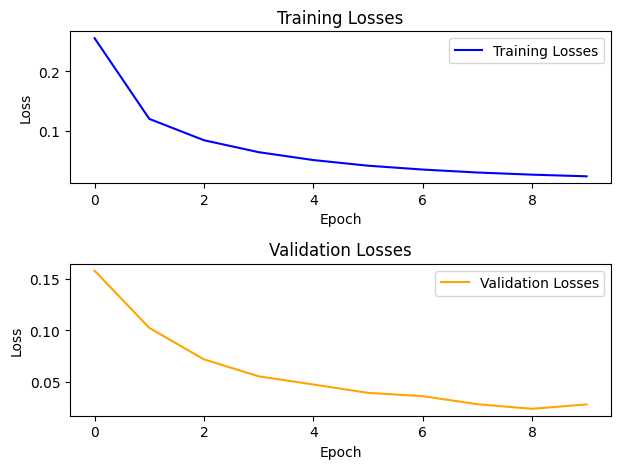

In [14]:
num_epochs = 10
learning_rate = 0.001
optimizer = optim.Adamax(model.parameters(), lr=learning_rate)
criterion = nn.BCEWithLogitsLoss()

model, train_losses, val_losses = learning(num_epochs, train_loader, val_loader, model, optimizer, criterion)

plt.subplot(2, 1, 1)
plt.plot(train_losses, label='Training Losses', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Losses')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(val_losses, label='Validation Losses', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Losses')
plt.legend()
plt.tight_layout()
plt.show()

### Evaluation (оценка качества модели)

100%|██████████| 6/6 [00:01<00:00,  4.74it/s]


IOU: 0.7176590094411213


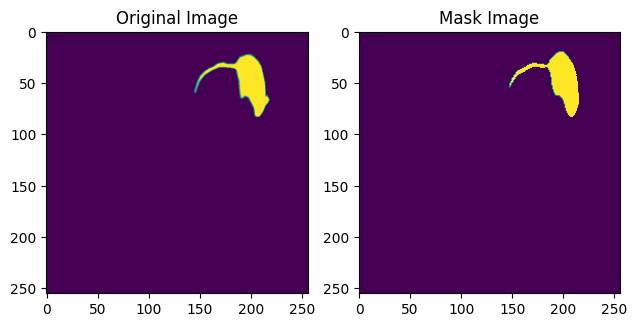

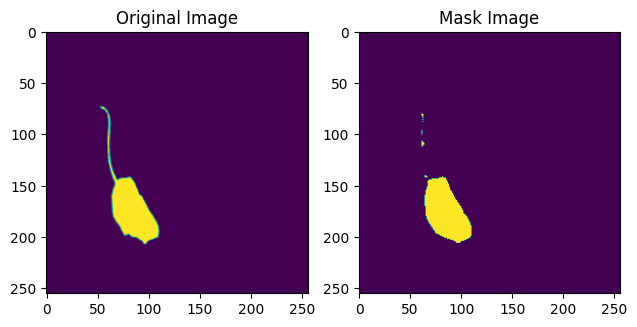

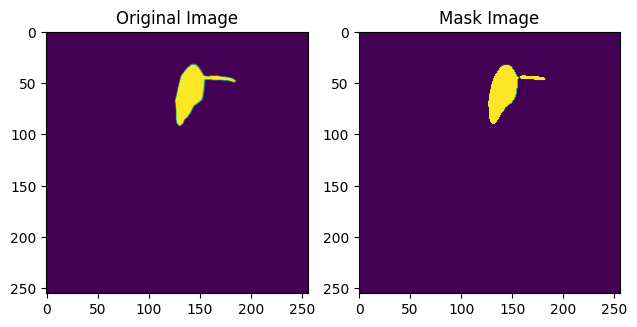

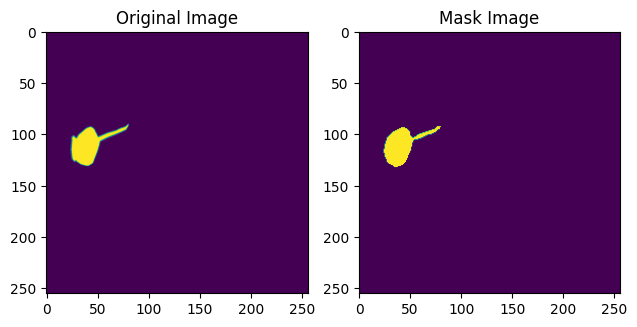

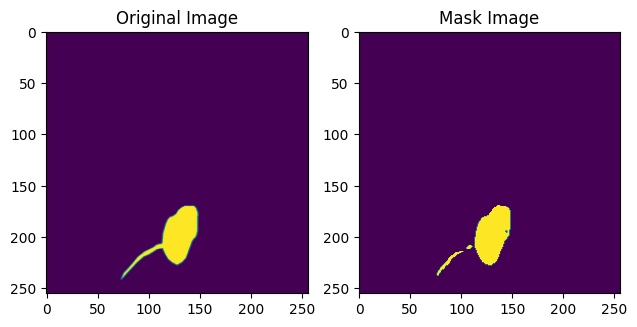

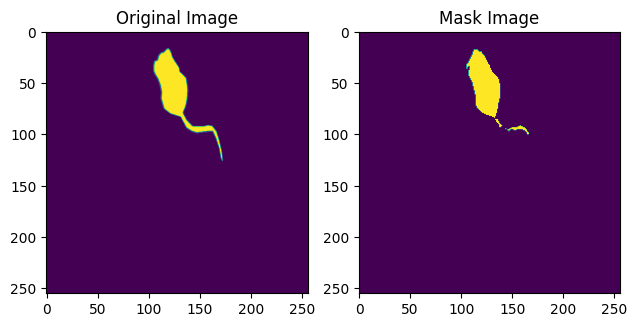

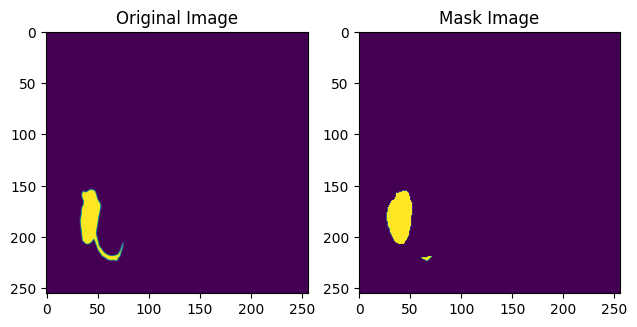

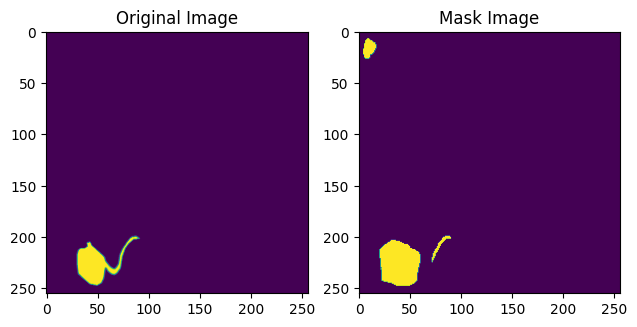

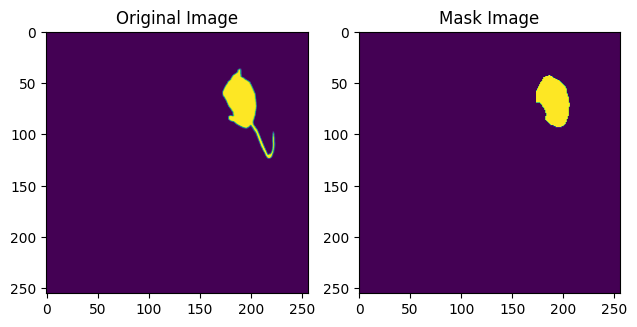

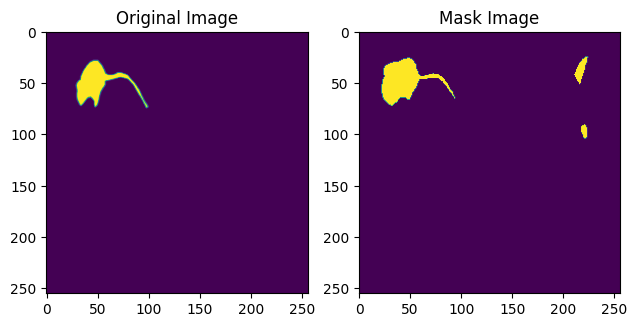

In [15]:
validation(model, val_loader, 10)

100%|██████████| 4/4 [00:00<00:00,  4.78it/s]


IOU: 0.7183672383760107


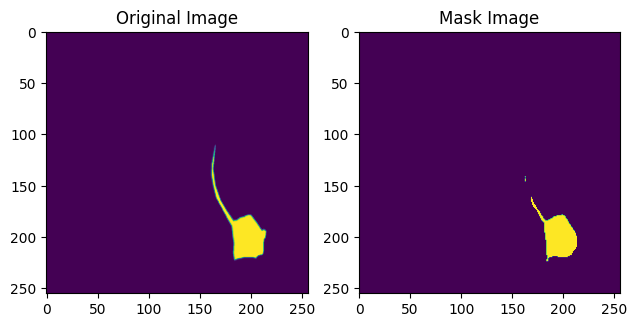

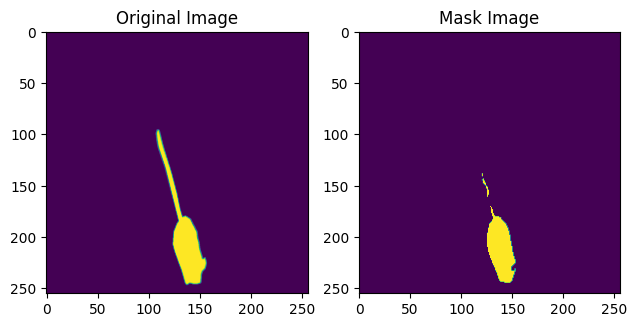

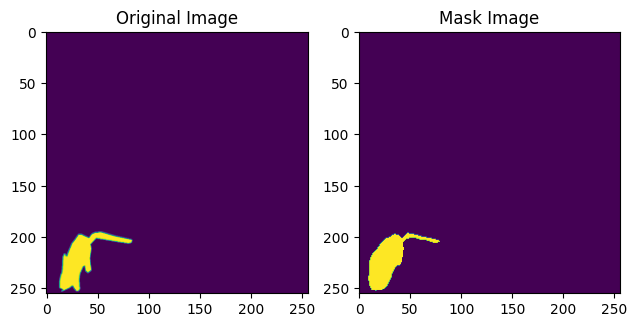

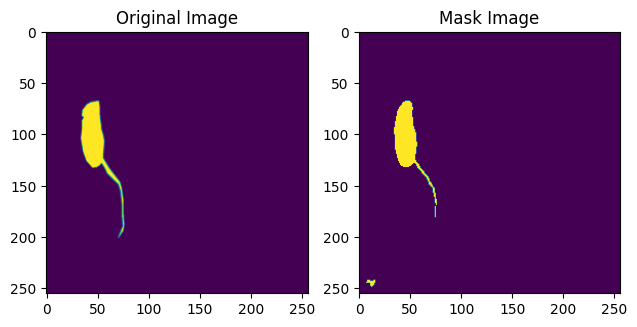

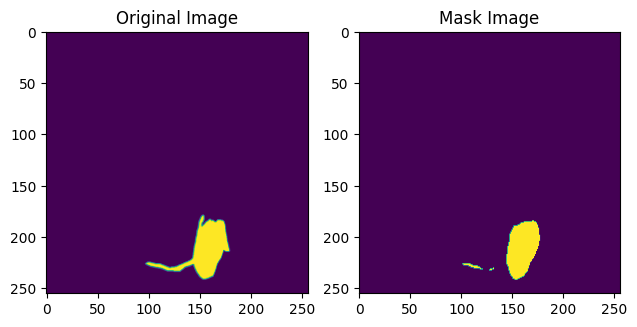

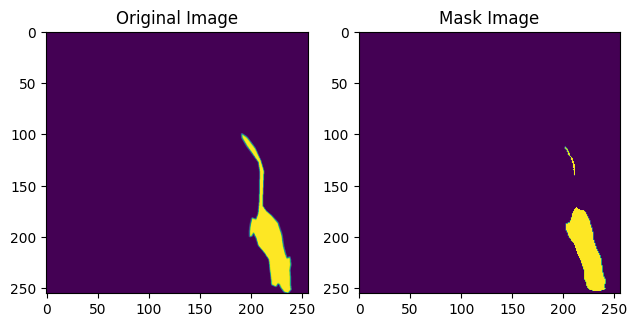

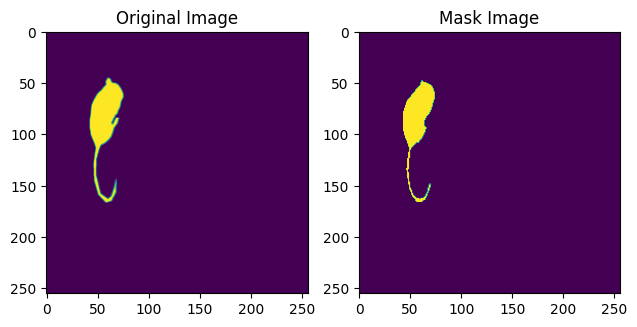

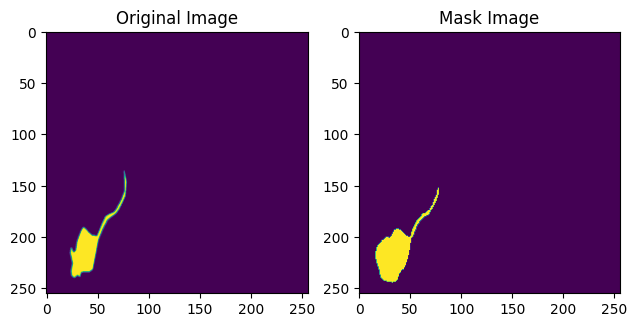

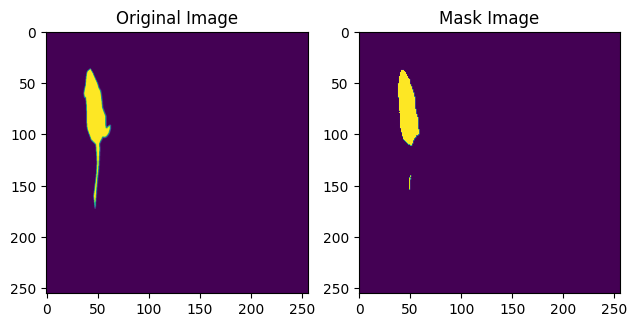

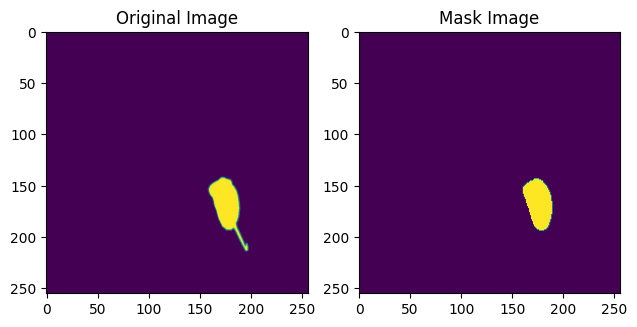

In [16]:
validation(model, test_loader, 10)